In [1]:
import pandas as pd

## Load Data

In [2]:
df = pd.read_csv('data/reliance/trials_data.csv')

df

,session_id,scenario_name,allocation_type,fund_a,fund_b,actual_return_a,actual_return_b,new_trial_num
0,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,initial,25.0,75.0,0.043368,0.378959,1
1,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,ai,13.0,87.0,0.043368,0.378959,1
2,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,final,25.0,75.0,0.043368,0.378959,1
3,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,initial,0.0,100.0,0.088148,0.038948,2
4,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,ai,40.0,60.0,0.088148,0.038948,2
...,...,...,...,...,...,...,...,...
12439,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,final,25.0,75.0,0.010689,0.038900,99
12440,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,initial,50.0,50.0,0.011969,-0.019207,100
12441,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,ai,66.0,34.0,0.011969,-0.019207,100
12442,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,final,50.0,50.0,0.011969,-0.019207,100


In [3]:
# 1. Drop any trial within a session where initial, AI, or final alloc was 50/50
mask_invalid = df.groupby(['session_id','new_trial_num'])['fund_a'] \
                 .transform(lambda x: x.eq(50).any())
df_valid = df[~mask_invalid].copy()

df_valid 

,session_id,scenario_name,allocation_type,fund_a,fund_b,actual_return_a,actual_return_b,new_trial_num
0,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,initial,25.0,75.0,0.043368,0.378959,1
1,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,ai,13.0,87.0,0.043368,0.378959,1
2,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,final,25.0,75.0,0.043368,0.378959,1
3,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,initial,0.0,100.0,0.088148,0.038948,2
4,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,ai,40.0,60.0,0.088148,0.038948,2
...,...,...,...,...,...,...,...,...
12243,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,ai,18.0,82.0,0.014858,-0.012513,34
12244,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,final,20.0,80.0,0.014858,-0.012513,34
12248,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,initial,20.0,80.0,0.013638,-0.141680,36
12249,ffb0fe6f-80e9-470b-9f6a-176908950a85,long_biased,ai,73.0,27.0,0.013638,-0.141680,36


In [4]:






# 2. Compute RAIR & RSR per session
session_results = []

for session_id, grp in df_valid.groupby('session_id'):
    scenario = grp['scenario_name'].iat[0]
    
    # pivot to get allocations & returns by allocation_type
    pt_a = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='fund_a', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    pt_b = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='fund_b', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    r_a  = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='actual_return_a', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    r_b  = grp.pivot_table(index='new_trial_num', columns='allocation_type',
                           values='actual_return_b', aggfunc='first') \
             .reindex(columns=['initial','ai','final'])
    
    # keep only complete trials
    complete = pt_a.notna().all(1) & pt_b.notna().all(1) & \
               r_a.notna().all(1) & r_b.notna().all(1)
    pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
    
    # compute directions
    p = (r_b['initial'] > r_a['initial']).astype(int)
    i = (pt_b['initial'] > pt_a['initial']).astype(int)
    a = (pt_b['ai']      > pt_a['ai']).astype(int)
    f = (pt_b['final']   > pt_a['final']).astype(int)
    
    # classify
    ai_corr = a == p
    follow  = f == a
    stick   = f == i
    
    # metrics
    CA   = ai_corr.sum()
    IA   = (~ai_corr).sum()
    CAIR = (ai_corr & follow).sum()
    CSR  = ((~ai_corr) & stick).sum()
    RAIR = CAIR/CA if CA>0 else float('nan')
    RSR  = CSR/IA if IA>0 else float('nan')
    
    session_results.append({
        'session_id': session_id,
        'scenario_name': scenario,
        'RAIR': RAIR,
        'RSR': RSR
    })

per_session = pd.DataFrame(session_results)

# 3. Compute mean RAIR & RSR per scenario
scenario_means = per_session.groupby('scenario_name')[['RAIR','RSR']].mean().reset_index()

# # Display both tables
# from ace_tools import display_dataframe_to_user
# display_dataframe_to_user("Per‐Session RAIR & RSR", per_session)
# display_dataframe_to_user("Mean RAIR & RSR by Scenario", scenario_means)





/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_73140/1461390077.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_73140/1461390077.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_73140/1461390077.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_73140/1461390077.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_a, pt_b, r_a, r_b = pt_a[complete], pt_b[complete], r_a[complete], r_b[complete]
/var/folders/wj/l2xl

In [5]:
per_session

,session_id,scenario_name,RAIR,RSR
0,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,1.000000,1.000000
1,0a23b02d-7b80-4df5-a1a0-e8fbc0276d6e,long_biased,0.681818,1.000000
2,0c7043c3-2af3-4372-b189-f1c57fda7150,long_unbiased,0.594595,0.851852
3,10d83f1f-77eb-44c5-8bb6-a7ecb25c8227,short_biased,1.000000,NaN
4,12fe94cb-f2f0-4ad0-a030-6c936c6c629e,long_unbiased,0.435897,0.700000
...,...,...,...,...
66,f386f3bc-e543-4d13-8b5f-8128dfe50ba6,short_biased,1.000000,NaN
67,f723fc6b-d6df-4448-8736-7e08e9f16aaf,short_unbiased,1.000000,0.000000
68,f91d8c66-4d61-4dcd-a362-9345f0ebf401,short_unbiased,1.000000,0.666667
69,fdb4ee6d-00b5-48e2-9338-ecfa01631d10,short_biased,1.000000,1.000000


In [6]:
 # Count non-missing RAIR and RSR per scenario
counts = per_session.groupby('scenario_name').agg(
    RAIR_count=('RAIR', 'count'),
    RSR_count=('RSR', 'count')
).reset_index()

print(counts)


    scenario_name  RAIR_count  RSR_count
0     long_biased          16         15
1   long_unbiased          20         18
2    short_biased          16          5
3  short_unbiased          18         15


In [7]:
scenario_means

,scenario_name,RAIR,RSR
0,long_biased,0.873113,0.727877
1,long_unbiased,0.532328,0.784378
2,short_biased,0.987500,0.400000
3,short_unbiased,0.833333,0.622222


## Plot the results

In [8]:
import matplotlib.pyplot as plt

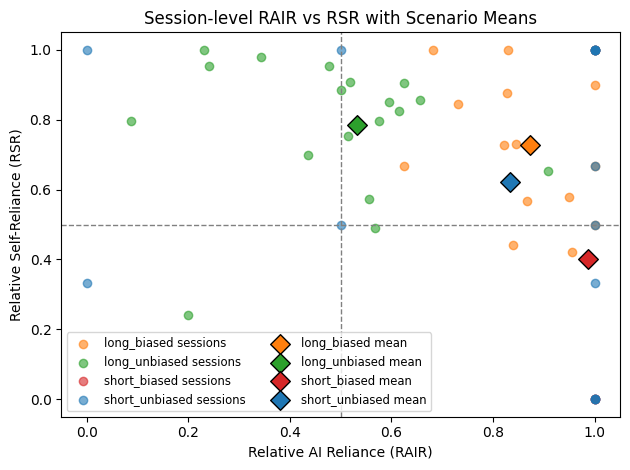

In [9]:


# Choose one distinct color per scenario
scenarios = per_session['scenario_name'].unique()
colors = plt.cm.tab10.colors  # up to 10 distinct colors
color_map = {sc: colors[i % len(colors)] for i, sc in enumerate(scenarios)}

fig, ax = plt.subplots()

# Plot session points
for sc, group in per_session.groupby('scenario_name'):
    ax.scatter(
        group['RAIR'], group['RSR'],
        color=color_map[sc],
        alpha=0.6,
        label=f"{sc} sessions"
    )

# Overlay the mean for each scenario
for _, row in scenario_means.iterrows():
    sc = row['scenario_name']
    ax.scatter(
        row['RAIR'], row['RSR'],
        marker='D', s=100,
        color=color_map[sc],
        edgecolor='k',
        label=f"{sc} mean"
    )

# Add dotted reference lines at 0.5
ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)
ax.axvline(0.5, linestyle='--', color='gray', linewidth=1)

ax.set_xlabel('Relative AI Reliance (RAIR)')
ax.set_ylabel('Relative Self-Reliance (RSR)')
ax.set_title('Session-level RAIR vs RSR with Scenario Means')

# Clean up legend: avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize='small', ncol=2)

plt.tight_layout()
plt.show()


## Kruskal-Wallis Test

In [10]:
import pandas as pd
from scipy.stats import kruskal

# 1. Load or reference your per-session DataFrame
# per_session = pd.read_csv('/mnt/data/per_session.csv')

# Ensure it has columns: session_id, scenario_name, RAIR, RSR

# 2. Prepare RAIR groups
rair_data = [
    grp['RAIR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 3. Kruskal-Wallis test for RAIR
H_rair, p_rair = kruskal(*rair_data)
print(f"Kruskal-Wallis for RAIR: H = {H_rair:.3f}, p = {p_rair:.3f}")

# 4. Prepare RSR groups
rsr_data = [
    grp['RSR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 5. Kruskal-Wallis test for RSR
H_rsr, p_rsr = kruskal(*rsr_data)
print(f"Kruskal-Wallis for RSR: H = {H_rsr:.3f}, p = {p_rsr:.3f}")


Kruskal-Wallis for RAIR: H = 31.382, p = 0.000
Kruskal-Wallis for RSR: H = 1.110, p = 0.775


In [11]:
import pandas as pd
from scipy.stats import kruskal, rankdata

# Assuming per_session DataFrame is in memory with columns: ['session_id', 'scenario_name', 'RAIR', 'RSR']

def kruskal_stats(df, metric):
    # Drop NaNs
    d = df.dropna(subset=[metric]).copy()
    
    # Group values by scenario
    groups = [grp[metric].values for _, grp in d.groupby('scenario_name')]
    
    # Kruskal-Wallis test
    H, p = kruskal(*groups)
    
    # Gesamtzahl der Fälle
    N = len(d)
    # Erwartungswert der Rangplätze
    E_rank = (N + 1) / 2
    
    # Ränge berechnen
    d['rank'] = rankdata(d[metric])
    
    # Rangsummen pro Gruppe
    grp_stats = (
        d.groupby('scenario_name')
         .agg(n=('rank','size'),
              R_sum=('rank','sum'),
              mean_rank=('rank','mean'))
         .reset_index()
    )
    # Mittlere Rangsummen über alle Gruppen
    mean_R_sum = grp_stats['R_sum'].mean()
    
    # Freiheitsgrade
    k = grp_stats.shape[0]
    dfree = k - 1
    
    # Varianz der Rangplätze
    var_ranks = (N**2 - 1) / 12
    
    # Ausgabe
    print(f"### Kruskal-Wallis für {metric} ###")
    print(f"H = {H:.3f}, p = {p:.3f}")
    print(f"Anzahl der Fälle (N) = {N}")
    print(f"Erwartungswert der Rangplätze = {E_rank:.3f}")
    print(f"Mittlere Rangsummen (Ø R_sum) = {mean_R_sum:.3f}")
    print(f"Freiheitsgrade = {dfree}")
    print(f"Varianz der Rangplätze = {var_ranks:.3f}\n")
    print("Gruppenstatistiken:")
    display(grp_stats)

# Run for RAIR
kruskal_stats(per_session, 'RAIR')

# Run for RSR
kruskal_stats(per_session, 'RSR')

### Kruskal-Wallis für RAIR ###
H = 31.382, p = 0.000
Anzahl der Fälle (N) = 70
Erwartungswert der Rangplätze = 35.500
Mittlere Rangsummen (Ø R_sum) = 621.250
Freiheitsgrade = 3
Varianz der Rangplätze = 408.250

Gruppenstatistiken:


,scenario_name,n,R_sum,mean_rank
0,long_biased,16,568.0,35.500000
1,long_unbiased,20,344.5,17.225000
2,short_biased,16,812.5,50.781250
3,short_unbiased,18,760.0,42.222222


### Kruskal-Wallis für RSR ###
H = 1.110, p = 0.775
Anzahl der Fälle (N) = 53
Erwartungswert der Rangplätze = 27.000
Mittlere Rangsummen (Ø R_sum) = 357.750
Freiheitsgrade = 3
Varianz der Rangplätze = 234.000

Gruppenstatistiken:


,scenario_name,n,R_sum,mean_rank
0,long_biased,15,399.0,26.600000
1,long_unbiased,18,522.0,29.000000
2,short_biased,5,104.5,20.900000
3,short_unbiased,15,405.5,27.033333


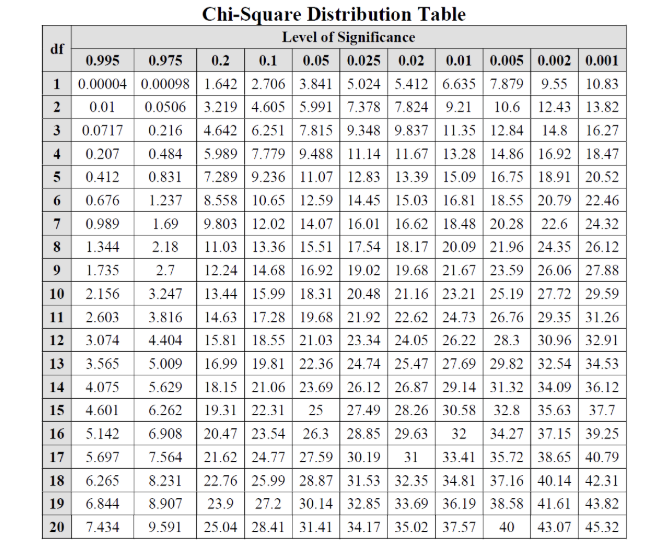

In [12]:

# Filter to only sessions with both RAIR & RSR
ps = per_session.dropna(subset=['RAIR', 'RSR'])

ps

,session_id,scenario_name,RAIR,RSR
0,089f4a30-cfa6-4c6a-8b48-4afa6555fbdc,short_unbiased,1.000000,1.000000
1,0a23b02d-7b80-4df5-a1a0-e8fbc0276d6e,long_biased,0.681818,1.000000
2,0c7043c3-2af3-4372-b189-f1c57fda7150,long_unbiased,0.594595,0.851852
4,12fe94cb-f2f0-4ad0-a030-6c936c6c629e,long_unbiased,0.435897,0.700000
6,1a8abf56-521e-460c-af74-7a5aae74109d,long_unbiased,0.575758,0.795455
7,20bd9ac0-179e-4b1b-9e49-cb3d84129936,long_biased,1.000000,0.900000
8,223a1856-abda-4ec5-9024-ca4c5c395633,long_unbiased,0.200000,0.241379
9,24c846f7-8c09-4270-904e-616d003cb73d,long_biased,0.867647,0.566667
10,2967e321-a244-4929-a148-d7e0d20ef7aa,long_biased,0.730159,0.846154
13,3b5ac0d7-bab4-45f7-8ed4-94711b7abdcc,long_unbiased,0.476190,0.954545


In [13]:
# 3. Compute mean RAIR & RSR per scenario
sm = ps.groupby('scenario_name')[['RAIR','RSR']].mean().reset_index()
sm

,scenario_name,RAIR,RSR
0,long_biased,0.864653,0.727877
1,long_unbiased,0.480364,0.784378
2,short_biased,1.000000,0.400000
3,short_unbiased,0.800000,0.622222


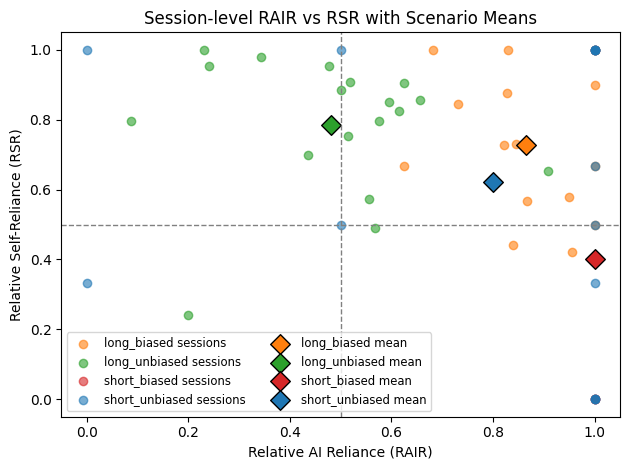

In [14]:


# Choose one distinct color per scenario
scenarios = ps['scenario_name'].unique()
colors = plt.cm.tab10.colors  # up to 10 distinct colors
color_map = {sc: colors[i % len(colors)] for i, sc in enumerate(scenarios)}

fig, ax = plt.subplots()

# Plot session points
for sc, group in ps.groupby('scenario_name'):
    ax.scatter(
        group['RAIR'], group['RSR'],
        color=color_map[sc],
        alpha=0.6,
        label=f"{sc} sessions"
    )

# Overlay the mean for each scenario
for _, row in sm.iterrows():
    sc = row['scenario_name']
    ax.scatter(
        row['RAIR'], row['RSR'],
        marker='D', s=100,
        color=color_map[sc],
        edgecolor='k',
        label=f"{sc} mean"
    )

# Add dotted reference lines at 0.5
ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)
ax.axvline(0.5, linestyle='--', color='gray', linewidth=1)

ax.set_xlabel('Relative AI Reliance (RAIR)')
ax.set_ylabel('Relative Self-Reliance (RSR)')
ax.set_title('Session-level RAIR vs RSR with Scenario Means')

# Clean up legend: avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize='small', ncol=2)

plt.tight_layout()
plt.show()


## Kruskal-Wallis Test

In [15]:
import pandas as pd
from scipy.stats import kruskal

# 1. Load or reference your per-session DataFrame
# per_session = pd.read_csv('/mnt/data/per_session.csv')

# Ensure it has columns: session_id, scenario_name, RAIR, RSR

# 2. Prepare RAIR groups
rair_data = [
    grp['RAIR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 3. Kruskal-Wallis test for RAIR
H_rair, p_rair = kruskal(*rair_data)
print(f"Kruskal-Wallis for RAIR: H = {H_rair:.3f}, p = {p_rair:.3f}")

# 4. Prepare RSR groups
rsr_data = [
    grp['RSR'].dropna().values
    for _, grp in per_session.groupby('scenario_name')
]

# 5. Kruskal-Wallis test for RSR
H_rsr, p_rsr = kruskal(*rsr_data)
print(f"Kruskal-Wallis for RSR: H = {H_rsr:.3f}, p = {p_rsr:.3f}")


Kruskal-Wallis for RAIR: H = 31.382, p = 0.000
Kruskal-Wallis for RSR: H = 1.110, p = 0.775
